In [2]:
import pandas as pd
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [3]:
grid_results = pd.read_hdf('../models/logreg_gridsearch_results.h5')
grid_model = load("../models/logreg_gridsearch_model.joblib")

In [4]:
grid_results[grid_results['param_clf__penalty'] == 'l1'].sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__max_iter,param_clf__penalty,param_clf__solver,param_qt__n_quantiles,param_qt__output_distribution,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
300,72.756925,4.252377,0.155686,0.023915,0.0701704,1000,l1,saga,10,uniform,...,0.555556,0.883333,0.850000,0.633333,0.833333,0.666667,0.933333,0.733333,0.124549,38
302,75.088097,9.539944,0.183864,0.062478,0.0701704,1000,l1,saga,50,uniform,...,0.522222,0.866667,0.850000,0.600000,0.816667,0.700000,0.933333,0.731111,0.125615,47
361,76.086014,12.128193,2.469697,0.317867,0.412463,1000,l1,saga,10,normal,...,0.477778,0.800000,0.916667,0.516667,0.816667,0.850000,0.850000,0.730556,0.149014,48
283,71.654892,6.625560,2.582913,0.079960,0.0388816,1000,l1,saga,50,normal,...,0.444444,0.833333,0.950000,0.500000,0.816667,0.900000,0.833333,0.730000,0.164414,50
303,71.750645,7.104787,2.612244,0.067948,0.0701704,1000,l1,saga,50,normal,...,0.433333,0.850000,0.933333,0.500000,0.800000,0.866667,0.850000,0.730000,0.162374,53


In [5]:
grid_results[grid_results['param_clf__penalty'] == 'l1'].sort_values('rank_test_score').iloc[0,:]

mean_fit_time                                                              72.7569
std_fit_time                                                               4.25238
mean_score_time                                                           0.155686
std_score_time                                                            0.023915
param_clf__C                                                             0.0701704
param_clf__max_iter                                                           1000
param_clf__penalty                                                              l1
param_clf__solver                                                             saga
param_qt__n_quantiles                                                           10
param_qt__output_distribution                                              uniform
params                           {'clf__C': 0.07017038286703822, 'clf__max_iter...
split0_test_score                                                         0.644444
spli

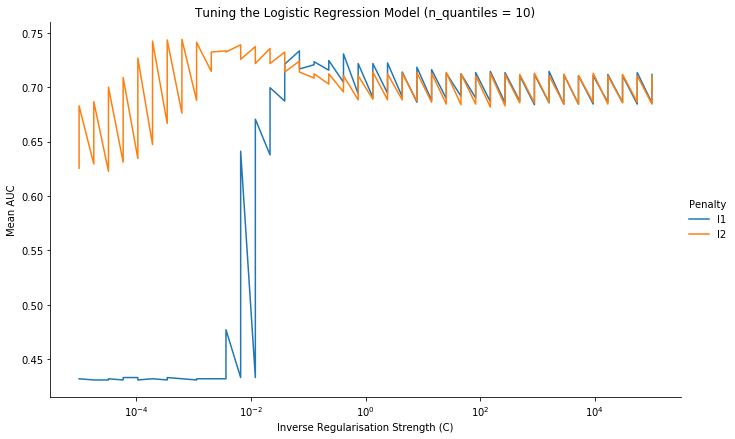

In [6]:
qt_10 = grid_results[grid_results['param_qt__n_quantiles'] == 10]
fg = sns.FacetGrid(data = qt_10, hue='param_clf__penalty', aspect=1.61, height=6)
fg.map(plt.semilogx, 'param_clf__C', 'mean_test_score').add_legend(title='Penalty')
fg.set(xlabel='Inverse Regularisation Strength (C)', ylabel='Mean AUC', title='Tuning the Logistic Regression Model (n_quantiles = 10)')
# plt.semilogx(grid_results['param_clf__C'], grid_results['mean_test_score'])
# fg.savefig('reports/figures/logreg_grid_penalty_qt_10')

In [7]:
# refit the model using best params
# do one for l2 and one for l1
X = pd.read_hdf('../data/features/filtered/filtered_0.05_.h5')
y = pd.read_hdf('../data/ach_at_combined_y.h5', key='y')

s = 1
for i in range(1,6):
    X.loc[90*(i-1):90*i,'subject'] = s
    s += 1
for i in range(1,7):
    X.loc[450+(60*(i-1)):450+(60*i),'subject'] = s
    s+=1
assert not any(pd.isna(X['subject']))

train = X[X['subject'] != 4].index
test = X[X['subject'] == 4].index

X_train, X_test, y_train, y_test = X.iloc[train,:], X.iloc[test,:], y.iloc[train], y.iloc[test]

In [8]:
best_l2 = Pipeline(steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=10,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('clf',
                 LogisticRegression(C=0.0006235507341273912, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)
best_l2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=10,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('clf',
                 LogisticRegression(C=0.0006235507341273912, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [9]:
l1_models = grid_results[grid_results['param_clf__penalty'] == 'l1']
best_l1_attr = l1_models.sort_values('rank_test_score').iloc[0,:]
best_l1_attr['params']

{'clf__C': 0.07017038286703822,
 'clf__max_iter': 1000,
 'clf__penalty': 'l1',
 'clf__solver': 'saga',
 'qt__n_quantiles': 10,
 'qt__output_distribution': 'uniform'}

In [10]:
best_l1 = Pipeline(steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=10,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('clf',
                 LogisticRegression(C=0.07017038286703822, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l1',
                                    random_state=None, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)
best_l1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('qt',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=10,
                                     output_distribution='normal',
                                     random_state=None, subsample=100000)),
                ('clf',
                 LogisticRegression(C=0.07017038286703822, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l1',
                                    random_state=None, solver='saga',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [11]:
y_pred_l2 = best_l2.predict(X_test)
y_pred_l1 = best_l1.predict(X_test)

y_t = pd.get_dummies(y_test)
y_p_l2 = pd.get_dummies(y_pred_l2)
y_p_l1 = pd.get_dummies(y_pred_l1)

print(confusion_matrix(y_test, y_pred_l2))
print(roc_auc_score(y_t,y_p_l2,multi_class='ovo'))
print(classification_report(y_test,y_pred_l2))

print(confusion_matrix(y_test, y_pred_l1))
print(roc_auc_score(y_t,y_p_l1,multi_class='ovo'))
print(classification_report(y_test,y_pred_l1))



[[ 0 29  0]
 [ 0 30  0]
 [ 0 30  1]]
0.499931693989071
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.34      1.00      0.50        30
           2       1.00      0.03      0.06        31

    accuracy                           0.34        90
   macro avg       0.45      0.34      0.19        90
weighted avg       0.46      0.34      0.19        90

[[ 0  7 22]
 [ 0 30  0]
 [ 0  8 23]]
0.2171071226681741
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.67      1.00      0.80        30
           2       0.51      0.74      0.61        31

    accuracy                           0.59        90
   macro avg       0.39      0.58      0.47        90
weighted avg       0.40      0.59      0.48        90



- The l2 Model pretty much classifies everything as Ach. This is a pretty terrible model.  
- The l1 Model does better in classifying AT, but still fails to identify any baseline observations.  

> we need more scoring methods
